# Chapter 10

## Section 10.2: Estimating A Single Data Point

In [1]:
# Listing 10.1: Dataset with missing value
data = [
    (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (0, None), (0, 1), (1, 0)
]

In [2]:
# Listing 10.2: The log‐likelihood function adapted for our data
from math import log

def log_likelihood(data, prob_a_b, prob_a_nb, prob_na_b, prob_na_nb):
    def get_prob(point):    
        if point[0] == 1 and point[1] == 1:
            return log(prob_a_b)
        elif point[0] == 1 and point[1] == 0:
            return log(prob_a_nb)
        elif point[0] == 0 and point[1] == 1:
            return log(prob_na_b)
        elif point[0] == 0 and point[1] == 0:
            return log(prob_na_nb)
        else:
            return log(prob_na_b+prob_na_nb)

    return sum(map(get_prob, data))

In [3]:
# Listing 10.3: Our known convenience function
from qiskit import QuantumCircuit, Aer, execute
from qiskit import ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import asin, sqrt

def prob_to_angle(prob):
    return 2*asin(sqrt(prob))

In [4]:
# Listing 10.4: the as‐pqc function
def as_pqc(cnt_quantum, with_qc, cnt_classical=1, shots=1, hist=False, measure=False):
    # Prepare the circuit with qubits and a classical bit to hold the measurement
    qr = QuantumRegister(cnt_quantum)
    cr = ClassicalRegister(cnt_classical)
    qc = QuantumCircuit(qr, cr) if measure else QuantumCircuit(qr)

    with_qc(qc, qr=qr, cr=cr)
    
    results = execute(
        qc,
        Aer.get_backend('statevector_simulator') if measure is False else Aer.get_backend('qasm_simulator'),
        shots=shots
    ).result().get_counts()
    
    return plot_histogram(results, figsize=(12,4)) if hist else results

In [5]:
# Listing 10.5: The quantum bayesian network
def qbn(data, hist=True): 
    def circuit(qc, qr=None, cr=None):
        list_a = list(filter(lambda item: item[0] == 1, data))
        list_na = list(filter(lambda item: item[0] == 0, data))
   
        # set the marginal probability of A
        qc.ry(prob_to_angle(
            len(list_a) / len(data)
        ), 0)

        # set the conditional probability of NOT A and (B / not B)
        qc.x(0)
        qc.cry(prob_to_angle(
            sum(list(map(lambda item: item[1], list_na))) /  len(list_na)
        ),0,1)
        qc.x(0)

        # set the conditional probability of A and (B / not B)
        qc.cry(prob_to_angle(
            sum(list(map(lambda item: item[1], list_a))) /  len(list_a)
        ),0,1)

    return as_pqc(2, circuit, hist=hist)

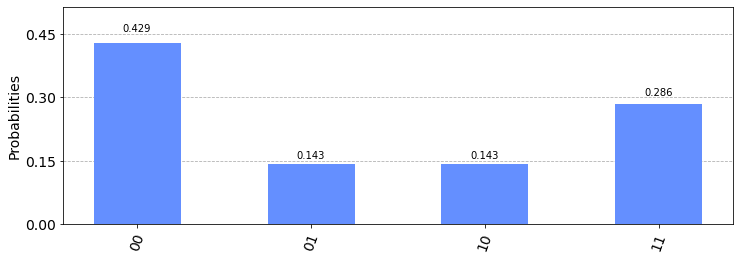

In [6]:
# Listing 10.6: Ignoring the missing data
qbn(list(filter(lambda item: item[1] is not None ,data)))

In [7]:
# Listing 10.7: Calculate the log‐likelihood when ignoring the missing data
def eval_qbn(model, prepare_data, data):
    results = model(prepare_data(data), hist=False)
    return round(log_likelihood(data, 
        results['11'], # prob_a_b
        results['01'], # prob_a_nb
        results['10'], # prob_na_b
        results['00']  # prob_na_nb
    ), 3)

eval_qbn(qbn, lambda dataset: list(filter(lambda item: item[1] is not None ,dataset)), data)

-9.499

In [8]:
# Listing 10.8: Calculate the log‐likelihood when filling in 0
eval_qbn(qbn, lambda dataset: list(map(lambda item: item if item[1] is not None else (item[0], 0) ,dataset)), data)

-9.481

In [9]:
# Listing 10.9: The updated eval‐qbn
def eval_qbn(model, prepare_data, data):
    results = model(prepare_data(data), hist=False)
    return (
        round(log_likelihood(data, 
            results['11'], # prob_a_b
            results['01'], # prob_a_nb
            results['10'], # prob_na_b
            results['00']  # prob_na_nb
        ), 3),
        results['10'] / (results['10'] + results['00'])
    )

In [10]:
# Listing 10.10: Evaluation of the guess
eval_qbn(qbn, lambda dataset: list(map(lambda item: item if item[1] is not None else (item[0], 0.5) ,dataset)), data)

(-9.476, 0.3)

In [11]:
# Listing 10.11: Refining the model
eval_qbn(qbn, lambda dataset: list(map(lambda item: item if item[1] is not None else (item[0], 0.3) ,dataset)), data)

(-9.452, 0.26)

In [12]:
# Listing 10.12: Further refining the model
eval_qbn(qbn, lambda dataset: list(map(lambda item: item if item[1] is not None else (item[0], 0.26) ,dataset)), data)

(-9.451, 0.252)

In [13]:
# Listing 10.13: Another iteration
eval_qbn(qbn, lambda dataset: list(map(lambda item: item if item[1] is not None else (item[0], 0.252) ,dataset)), data)

(-9.451, 0.2504)

## Section 10.3: Estimating A Variable

In [15]:
# Listing 10.14: Apply the known
import pandas as pd
train = pd.read_csv('./data/train.csv')

# the maximum age of a passenger we consider as a child
max_child_age = 8

# probability of being a child
population_child = train[train.Age.le(max_child_age)]
p_child = len(population_child)/len(train)

# probability of being female
population_female = train[train.Sex.eq("female")]
p_female = len(population_female)/len(train)

# positions of the qubits
QPOS_ISCHILD = 0
QPOS_SEX = 1

def apply_ischild_sex(qc):
    # set the marginal probability of isChild
    qc.ry(prob_to_angle(p_child), QPOS_ISCHILD)

    # set the marginal probability of Sex
    qc.ry(prob_to_angle(p_female), QPOS_SEX)

In [24]:
def ccry(qc, theta, control1, control2, controlled):
    qc.cry(theta/2, control2, controlled)
    qc.cx(control1, control2)
    qc.cry(-theta/2, control2, controlled)
    qc.cx(control1, control2)
    qc.cry(theta/2, control1, controlled)

In [22]:
# Listing 10.15: Represent the norm
# position of the qubit representing the norm
QPOS_NORM = 2

def apply_norm(qc, norm_params):
    """
    norm_params = {
        'p_norm_am': 0.25,
        'p_norm_af': 0.35,
        'p_norm_cm': 0.45,
        'p_norm_cf': 0.55
    }
    """

    # set the conditional probability of Norm given adult/male
    qc.x(QPOS_ISCHILD)
    qc.x(QPOS_SEX)
    ccry(qc, prob_to_angle(
        norm_params['p_norm_am']
    ),QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)
    qc.x(QPOS_ISCHILD)
    qc.x(QPOS_SEX)

    # set the conditional probability of Norm given adult/female
    qc.x(QPOS_ISCHILD)
    ccry(qc, prob_to_angle(
        norm_params['p_norm_af']
    ),QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)
    qc.x(QPOS_ISCHILD)

    # set the conditional probability of Norm given child/male
    qc.x(QPOS_SEX)
    ccry(qc, prob_to_angle(
        norm_params['p_norm_cm']
    ),QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)
    qc.x(QPOS_SEX)

    # set the conditional probability of Norm given child/female
    ccry(qc, prob_to_angle(
        norm_params['p_norm_cf']
    ),QPOS_ISCHILD, QPOS_SEX, QPOS_NORM)

In [17]:
# Listing 10.16: Calculate the probabilities related to the ticket‐class
pop_first = train[train.Pclass.eq(1)]
surv_first =  round(len(pop_first[pop_first.Survived.eq(1)])/len(pop_first), 2)
p_first = round(len(pop_first)/len(train), 2)

pop_second = train[train.Pclass.eq(2)]
surv_second =  round(len(pop_second[pop_second.Survived.eq(1)])/len(pop_second), 2)
p_second = round(len(pop_second)/len(train), 2)

pop_third = train[train.Pclass.eq(3)]
surv_third =  round(len(pop_third[pop_third.Survived.eq(1)])/len(pop_third), 2)
p_third = round(len(pop_third)/len(train), 2)

print("First class: {} of the passengers, survived: {}".format(p_first,surv_first))
print("Second class: {} of the passengers, survived: {}".format(p_second,surv_second))
print("Third class: {} of the passengers, survived: {}".format(p_third,surv_third))

First class: 0.24 of the passengers, survived: 0.63
Second class: 0.21 of the passengers, survived: 0.47
Third class: 0.55 of the passengers, survived: 0.24


In [18]:
# Listing 10.17: Represent the ticket‐class
# positions of the qubits
QPOS_FIRST = 3
QPOS_SECOND = 4
QPOS_THIRD = 5

def apply_class(qc):
    # set the marginal probability of Pclass=1st
    qc.ry(prob_to_angle(p_first), QPOS_FIRST)

    qc.x(QPOS_FIRST)
    # set the marginal probability of Pclass=2nd
    qc.cry(prob_to_angle(p_second/(1-p_first)), QPOS_FIRST, QPOS_SECOND)

    # set the marginal probability of Pclass=3rd    
    qc.x(QPOS_SECOND)
    ccry(qc, prob_to_angle(p_third/(1-p_first-p_second)), QPOS_FIRST, QPOS_SECOND, QPOS_THIRD)
    qc.x(QPOS_SECOND)
    qc.x(QPOS_FIRST)

In [19]:
# Listing 10.18: Represent survival
# position of the qubit
QPOS_SURV = 6

def apply_survival(qc, surv_params):    
    """
    surv_params = {
        'p_surv_f1': 0.3,
        'p_surv_f2': 0.4,
        'p_surv_f3': 0.5,
        'p_surv_u1': 0.6,
        'p_surv_u2': 0.7,
        'p_surv_u3': 0.8
    }
    """

    # set the conditional probability of Survival given unfavored by norm
    qc.x(QPOS_NORM)
    ccry(qc, prob_to_angle(
        surv_params['p_surv_u1']
    ),QPOS_NORM, QPOS_FIRST, QPOS_SURV)

    ccry(qc, prob_to_angle(
        surv_params['p_surv_u2']
    ),QPOS_NORM, QPOS_SECOND, QPOS_SURV)

    ccry(qc, prob_to_angle(
        surv_params['p_surv_u3']
    ),QPOS_NORM, QPOS_THIRD, QPOS_SURV)
    qc.x(QPOS_NORM)

    # set the conditional probability of Survival given favored by norm
    ccry(qc, prob_to_angle(
        surv_params['p_surv_f1']
    ),QPOS_NORM, QPOS_FIRST, QPOS_SURV)

    ccry(qc, prob_to_angle(
        surv_params['p_surv_f2']
    ),QPOS_NORM, QPOS_SECOND, QPOS_SURV)

    ccry(qc, prob_to_angle(
        surv_params['p_surv_f3']
    ),QPOS_NORM, QPOS_THIRD, QPOS_SURV)

In [20]:
# Listing 10.19: The quantum bayesian network
QUBITS = 7

def qbn_titanic(norm_params, surv_params, hist=True, measure=False, shots=1): 
    def circuit(qc, qr=None, cr=None):
        apply_ischild_sex(qc)
        apply_norm(qc, norm_params)
        apply_class(qc)
        apply_survival(qc, surv_params)

    return as_pqc(QUBITS, circuit, hist=hist, measure=measure, shots=shots)

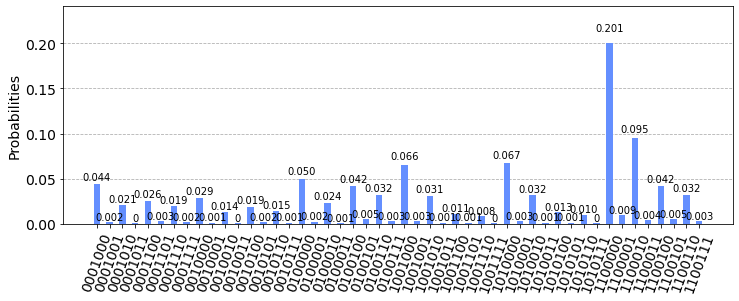

In [25]:
# Listing 10.20: Try the QBN
norm_params = {
    'p_norm_am': 0.25,
    'p_norm_af': 0.35,
    'p_norm_cm': 0.45,
    'p_norm_cf': 0.55
}

surv_params = {
    'p_surv_f1': 0.3,
    'p_surv_f2': 0.4,
    'p_surv_f3': 0.5,
    'p_surv_u1': 0.6,
    'p_surv_u2': 0.7,
    'p_surv_u3': 0.8
}

qbn_titanic(norm_params, surv_params, hist=True)

In [26]:
# Listing 10.21: Calculate the parameters of the norm
def calculate_norm_params(passengers):
    # the different populations in our data
    pop_children = passengers[passengers.IsChild.eq(1)]
    pop_adults = passengers[passengers.IsChild.eq(0)]

    # combinations of being a child and gender
    pop_am = pop_adults[pop_adults.Sex.eq('male')]
    pop_af = pop_adults[pop_adults.Sex.eq('female')]
    pop_cm = pop_children[pop_children.Sex.eq('male')]
    pop_cf = pop_children[pop_children.Sex.eq('female')]

    norm_params = {
        'p_norm_am': pop_am.Norm.sum() /  len(pop_am),
        'p_norm_af': pop_af.Norm.sum() /  len(pop_af),
        'p_norm_cm': pop_cm.Norm.sum() /  len(pop_cm),
        'p_norm_cf': pop_cf.Norm.sum() /  len(pop_cf),
    }

    return norm_params

In [27]:
# Listing 10.22: Calculate the parameters of survival
def calculate_surv_params(passengers):
    # all survivors
    survivors = passengers[passengers.Survived.eq(1)]
    
    # weight the passenger
    def weight_passenger(norm, pclass):
        return lambda passenger: (passenger[0] if norm else 1-passenger[0]) * (1 if passenger[1] == pclass else 0)

    # calculate the probability to survive
    def calc_prob(norm, pclass):
        return sum(list(map(
            weight_passenger(norm, pclass),
            list(zip(survivors['Norm'], survivors['Pclass']))
        ))) / sum(list(map(
            weight_passenger(norm, pclass), 
            list(zip(passengers['Norm'], passengers['Pclass']))
        )))
    
    surv_params = {
        'p_surv_f1': calc_prob(True, 1),
        'p_surv_f2': calc_prob(True, 2),
        'p_surv_f3': calc_prob(True, 3),
        'p_surv_u1': calc_prob(False, 1),
        'p_surv_u2': calc_prob(False, 2),
        'p_surv_u3': calc_prob(False, 3)
    }

    return surv_params

In [28]:
# Listing 10.23: Prepare the data
def prepare_data(passengers, params):
    """
    params = {
        'p_norm_cms': 0.45,
        'p_norm_cmd': 0.46,
        'p_norm_cfs': 0.47,
        'p_norm_cfd': 0.48,
        'p_norm_ams': 0.49,
        'p_norm_amd': 0.51,
        'p_norm_afs': 0.52,
        'p_norm_afd': 0.53,
    }
    """
    # is the passenger a child?
    passengers['IsChild'] = passengers['Age'].map(lambda age: 0 if age > max_child_age else 1)

    # the probability of favored by norm given Age, Sex, and Survival
    passengers['Norm'] = list(map(
        lambda item: params['p_norm_{}{}{}'.format(
            'a' if item[0] == 0 else 'c',
            item[1][0],
            'd' if item[2] == 0 else 's'
        )],
        list(zip(passengers['IsChild'], passengers['Sex'], passengers['Survived']))
    ))
    return passengers

In [29]:
# Listing 10.24: Initialize the parameters
# Step 0: Initialize the parameter values 
params = {
    'p_norm_cms': 0.45,
    'p_norm_cmd': 0.46,
    'p_norm_cfs': 0.47,
    'p_norm_cfd': 0.48,
    'p_norm_ams': 0.49,
    'p_norm_amd': 0.51,
    'p_norm_afs': 0.52,
    'p_norm_afd': 0.53,
}

In [30]:
# Listing 10.25: Run the qbn
passengers = prepare_data(train, params)
results = qbn_titanic(calculate_norm_params(passengers), calculate_surv_params(passengers), hist=False)

In [31]:
# Listing 10.26: Get a list of relevant states
def filter_states(states, position, value):
    return list(filter(lambda item: item[0][QUBITS-1-position] == str(value), states))

In [32]:
# Listing 10.27: The states with surviving passengers
filter_states(results.items(), QPOS_SURV, '1')

[('1001000', 0.04521802427481),
 ('1001001', 0.003204510969179),
 ('1001010', 0.023809598395179),
 ('1001011', 0.001694956632945),
 ('1001100', 0.046710931136364),
 ('1001101', 0.002724433421988),
 ('1001110', 0.026223030341536),
 ('1001111', 0.001531873108259),
 ('1010000', 0.029950610381473),
 ('1010001', 0.002122539872988),
 ('1010010', 0.015770525499731),
 ('1010011', 0.001122671468756),
 ('1010100', 0.030453061368568),
 ('1010101', 0.001776186776328),
 ('1010110', 0.017096031546221),
 ('1010111', 0.000998700403519),
 ('1100000', 0.040619362913079),
 ('1100001', 0.002878613033266),
 ('1100010', 0.021388168402732),
 ('1100011', 0.001522579982202),
 ('1100100', 0.040445280069615),
 ('1100101', 0.002358986860305),
 ('1100110', 0.022705559076552),
 ('1100111', 0.001326392674849)]

In [33]:
# Listing 10.28: Calculate the marginal probability to survive
def sum_states(states):
    return sum(map(lambda item: item[1], states))

sum_states(filter_states(results.items(), QPOS_SURV, '1'))

0.383652628610444

In [34]:
# Listing 10.29: The log‐likelihood function adapted for our data
def log_likelihood_titanic(data, results):
    states = results.items()
    
    def calc_prob(norm_val, ischild_val, sex_val, surv_val):
        return sum_states(
            filter_states(
                filter_states(
                    filter_states(
                        filter_states(states, QPOS_SEX, sex_val),
                        QPOS_ISCHILD, ischild_val
                    ), QPOS_SURV, surv_val
                ), QPOS_NORM, norm_val))
        
    probs = {
        'p_fcms': calc_prob('1', '1', '0', '1'),
        'p_fcmd': calc_prob('1', '1', '0', '0'),
        'p_fcfs': calc_prob('1', '1', '1', '1'),
        'p_fcfd': calc_prob('1', '1', '1', '0'),
        'p_fams': calc_prob('1', '0', '0', '1'),
        'p_famd': calc_prob('1', '0', '0', '0'),
        'p_fafs': calc_prob('1', '0', '1', '1'),
        'p_fafd': calc_prob('1', '0', '1', '0'),
        'p_ucms': calc_prob('0', '1', '0', '1'),
        'p_ucmd': calc_prob('0', '1', '0', '0'),
        'p_ucfs': calc_prob('0', '1', '1', '1'),
        'p_ucfd': calc_prob('0', '1', '1', '0'),
        'p_uams': calc_prob('0', '0', '0', '1'),
        'p_uamd': calc_prob('0', '0', '0', '0'),
        'p_uafs': calc_prob('0', '0', '1', '1'),
        'p_uafd': calc_prob('0', '0', '1', '0'),
    }

    return round(sum(map(
        lambda item: log(probs['p_{}{}{}{}'.format(
                'u',
                'a' if item[1] == 0 else 'c',
                item[2][0],
                'd' if item[3] == 0 else 's'
            )] + probs['p_{}{}{}{}'.format(
                'f',
                'a' if item[1] == 0 else 'c',
                item[2][0],
                'd' if item[3] == 0 else 's'
            )]
        ),
        list(zip(data['Norm'], data['IsChild'], data['Sex'], data['Survived']))
    )), 3)

In [35]:
# Listing 10.30: Calculate the log‐likelihood
log_likelihood_titanic(train, results)

-1860.391

In [36]:
# Listing 10.31: Obtain new parameter values from the results
def to_params(results):
    states = results.items()
    
    def calc_norm(ischild_val, sex_val, surv_val):
        pop = filter_states(filter_states(filter_states(states, QPOS_SEX, sex_val), QPOS_ISCHILD, ischild_val), QPOS_SURV, surv_val)

        p_norm = sum(map(lambda item: item[1], filter_states(pop, QPOS_NORM, '1')))
        p_total = sum(map(lambda item: item[1], pop))
        return p_norm / p_total


    return {
        'p_norm_cms': calc_norm('1', '0', '1'),
        'p_norm_cmd': calc_norm('1', '0', '0'),
        'p_norm_cfs': calc_norm('1', '1', '1'),
        'p_norm_cfd': calc_norm('1', '1', '0'),
        'p_norm_ams': calc_norm('0', '0', '1'),
        'p_norm_amd': calc_norm('0', '0', '0'),
        'p_norm_afs': calc_norm('0', '1', '1'),
        'p_norm_afd': calc_norm('0', '1', '0'),
    }

In [37]:
# Listing 10.32: Calcualte new parameters
to_params(results)

{'p_norm_cms': 0.45532583440735436,
 'p_norm_cmd': 0.4593883474337892,
 'p_norm_cfs': 0.47052387314654737,
 'p_norm_cfd': 0.47460383062928546,
 'p_norm_ams': 0.5039016630401505,
 'p_norm_amd': 0.5079933634215915,
 'p_norm_afs': 0.5199079166576689,
 'p_norm_afd': 0.5239923091774149}

In [38]:
# Listing 10.33: The recursive training automatism
def train_qbn_titanic(passengers, params, iterations):
    if iterations > 0:
        new_params = train_qbn_titanic(passengers, params, iterations - 1)

        passengers = prepare_data(passengers, new_params)
        results = qbn_titanic(calculate_norm_params(passengers), calculate_surv_params(passengers), hist=False)

        print ('The log-likelihood after {} iteration(s) is {}'.format(iterations, log_likelihood_titanic(passengers, results)))
        return to_params(results)
    
    return params

In [39]:
# Listing 10.34: Train the QBN
trained_params = train_qbn_titanic(train, {
    'p_norm_cms': 0.45,
    'p_norm_cmd': 0.46,
    'p_norm_cfs': 0.47,
    'p_norm_cfd': 0.48,
    'p_norm_ams': 0.49,
    'p_norm_amd': 0.51,
    'p_norm_afs': 0.52,
    'p_norm_afd': 0.53,
}, 25)

The log-likelihood after 1 iteration(s) is -1860.391
The log-likelihood after 2 iteration(s) is -1860.355
The log-likelihood after 3 iteration(s) is -1860.332
The log-likelihood after 4 iteration(s) is -1860.3
The log-likelihood after 5 iteration(s) is -1860.243
The log-likelihood after 6 iteration(s) is -1860.13
The log-likelihood after 7 iteration(s) is -1859.901
The log-likelihood after 8 iteration(s) is -1859.426
The log-likelihood after 9 iteration(s) is -1858.439
The log-likelihood after 10 iteration(s) is -1856.393
The log-likelihood after 11 iteration(s) is -1852.213
The log-likelihood after 12 iteration(s) is -1843.99
The log-likelihood after 13 iteration(s) is -1829.057
The log-likelihood after 14 iteration(s) is -1805.719
The log-likelihood after 15 iteration(s) is -1777.24
The log-likelihood after 16 iteration(s) is -1752.49
The log-likelihood after 17 iteration(s) is -1737.602
The log-likelihood after 18 iteration(s) is -1730.95
The log-likelihood after 19 iteration(s) is 

In [40]:
# Listing 10.35: The parameters after training
trained_params

{'p_norm_cms': 0.6021334301303094,
 'p_norm_cmd': 0.07088902981523437,
 'p_norm_cfs': 0.9904336919724537,
 'p_norm_cfd': 0.8392179490424515,
 'p_norm_ams': 0.49195927424087027,
 'p_norm_amd': 0.04654642501038004,
 'p_norm_afs': 0.9978526500251851,
 'p_norm_afd': 0.9590619707414763}

In [41]:
# Listing 10.36: Pre‐processing
def pre_process(passenger):
    return (passenger['IsChild'] == 1, passenger['Sex'] == 'female', passenger['Pclass'])

In [42]:
# Listing 10.37: Apply the known data on the quantum circuit
def apply_known(qc, is_child, is_female, pclass):
    if is_child:
        qc.x(QPOS_ISCHILD)

    if is_female:
        qc.x(QPOS_SEX)
    
    qc.x(QPOS_FIRST if pclass == 1 else (QPOS_SECOND if pclass == 2 else QPOS_THIRD))

In [43]:
# Listing 10.38: Get the trained QBN
def get_trained_qbn(passengers, params):

    prepared_passengers = prepare_data(passengers, params)
    norm_params = calculate_norm_params(prepared_passengers)
    surv_params = calculate_surv_params(prepared_passengers)

    def trained_qbn_titanic(passenger):
        (is_child, is_female, pclass) = passenger

        def circuit(qc, qr, cr):
            apply_known(qc, is_child, is_female, pclass)
            apply_norm(qc, norm_params)
            apply_survival(qc, surv_params)
            
            qc.measure(qr[QPOS_SURV], cr[0])
        
        return as_pqc(QUBITS, circuit, hist=False, measure=True, shots=100)

    return trained_qbn_titanic

In [44]:
# Listing 10.39: Post‐processing
def post_process(counts):
    """
    counts -- the result of the quantum circuit execution
    returns the prediction
    """
    #print (counts)
    p_surv = counts['1'] if '1' in counts.keys() else 0
    p_died = counts['0'] if '0' in counts.keys() else 0

    #return int(list(map(lambda item: item[0], counts.items()))[0])
    return 1 if p_surv > p_died else 0

In [46]:
# REDEFINE OR IMPORT THE FUNCTIONS OF CHAPTER 2
from sklearn.metrics import confusion_matrix, precision_score, recall_score
def run(f_classify, x):
    return list(map(f_classify, x))

def specificity(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[0][1]) if (matrix[0][0]+matrix[0][1] > 0) else 0

def npv(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[1][0]) if (matrix[0][0]+matrix[1][0] > 0) else 0

def classifier_report(name, run, classify, input, labels):
    cr_predictions = run(classify, input)
    cr_cm = confusion_matrix(labels, cr_predictions)

    cr_precision = precision_score(labels, cr_predictions)
    cr_recall = recall_score(labels, cr_predictions)
    cr_specificity = specificity(cr_cm)
    cr_npv = npv(cr_cm)
    cr_level = 0.25*(cr_precision + cr_recall + cr_specificity + cr_npv)

    print('The precision score of the {} classifier is {:.2f}'
        .format(name, cr_precision))
    print('The recall score of the {} classifier is {:.2f}'
        .format(name, cr_recall))
    print('The specificity score of the {} classifier is {:.2f}'
        .format(name, cr_specificity))
    print('The npv score of the {} classifier is {:.2f}'
        .format(name, cr_npv))
    print('The information level is: {:.2f}'
        .format(cr_level))
#CAPTION A reusable function to unmask the hypocrite classifier

In [47]:
# Listing 10.40: Run the Quantum Naive Bayes Classifier
# redefine the run-function
def run(f_classify, data):
    return [f_classify(data.iloc[i]) for i in range(0,len(data))]

# get the simple qbn
trained_qbn = get_trained_qbn(train, trained_params)

# evaluate the Quantum Bayesian Network
classifier_report("QBN",
    run,
    lambda passenger: post_process(trained_qbn(pre_process(passenger))),
    passengers,
    train['Survived'])

The precision score of the QBN classifier is 0.78
The recall score of the QBN classifier is 0.61
The specificity score of the QBN classifier is 0.89
The npv score of the QBN classifier is 0.78
The information level is: 0.77
